In [2]:
%matplotlib inline

# sklearn.cluster 聚类
- cluster.AffinityPropagation 基于图的聚类
特别适合高维、多类数据快速聚类，相比传统的聚类算法，该算法算是比较新的，从聚类性能和效率方面都有大幅度的提升。
    - 不需要指定聚类的个数

- cluster.AgglomerativeClustering
    - 不能predict

- cluster.Birch
- cluster.DBSCAN
Density-Based Spatial Clustering of Applications with Noise
通过邻域大小来聚类，效果不错
    - 不需要指定聚类的个数
    - 不能predict
    - 噪声样本被标记为-1（预测的类不属于任何一类）

- cluster.FeatureAgglomeration
特征聚集 Feature agglomeration
把那些效果或行为相似的特征起来，达到降维的目的。

- cluster.KMeans
- cluster.MiniBatchKMeans
适合大量数据，速度快，没有KMeans精确

- cluster.MeanShift
    - 不需要指定聚类的个数

- cluster.OPTICS
Ordering Points To Identify the Clustering Structure
（类似的DBSCAN，效果不如DBSCAN）
    - 不需要指定聚类的个数
    - 不能predict
    - 噪声样本点被标记为-1

- cluster.SpectralClustering
谱聚类，效果不错
    - 不能predict

- mixture.BayesianGaussianMixture
- mixture.GaussianMixture
效果还行
    - 可以预测每个类别的概率


## 双聚类
https://www.cnblogs.com/lc1217/p/9257150.html
分别对矩阵的行和列进行聚类，然后合并聚类结果
- cluster.SpectralBiclustering
- cluster.SpectralCoclustering

In [3]:
from sklearn import cluster

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

In [4]:
data_X, data_y = load_iris(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.3)

esl = cluster.KMeans(3)

model = esl.fit(X_train, y_train)

In [5]:
model.score(X_train, y_train)



-59.1004663657855

In [6]:
model.score(X_test, y_test)



-20.270326221781758

In [7]:
model.predict(X_test)



array([1, 0, 1, 2, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 1, 0, 1, 0, 0, 2, 1, 2,
       0, 1, 1, 1, 1, 2, 2, 1, 0, 1, 0, 0, 2, 0, 0, 1, 0, 2, 2, 1, 2, 2,
       1])

In [8]:
y_test


array([0, 2, 0, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1, 0, 1, 0, 2, 2, 1, 0, 2,
       2, 0, 0, 0, 0, 1, 1, 0, 1, 0, 2, 2, 1, 2, 2, 0, 2, 1, 1, 0, 1, 1,
       0])

In [9]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice


In [52]:
np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
# 生成环形数据(X只能生成2维数据，y输出{0,1})
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
# 生成月亮形数据(X只能生成2维数据，y输出{0,1})
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
# 生成块状数据(默认2个维度，3个中心（y有三个）)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
# 无结构随机数据(2指的是2列也就是2个维度)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
# 生成块状数据(默认2个维度，3个中心（y有三个）) 做矩阵乘法，相当于把数据做了变形缩放等操作
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# 生成块状数据(默认2个维度，3个中心（y有三个）) 三个方差均分别是[1.0, 2.5, 0.5]
# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2,
                     'min_samples': 20, 'xi': 0.25}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2,
              'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
    (aniso, {'eps': .15, 'n_neighbors': 2,
             'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
    (blobs, {}),
    (no_structure, {})]

AttributeError: 'list' object has no attribute 'make_circles'

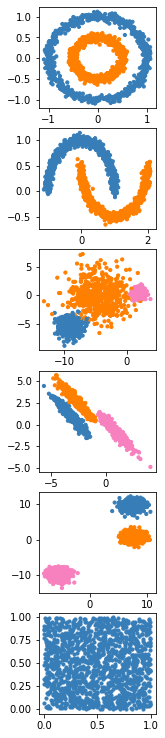

In [51]:
plt.figure(figsize=(2.1, 13))
plot_num = 1
for data in datasets:
    plt.subplot(len(datasets), 1, plot_num)
    plot_num+=1
    X = data[0][0]
    y = data[0][1]
    colors = np.empty_like(y,dtype=object)
    colors[y==0] = '#377eb8'
    colors[y==1] = '#ff7f00'
    colors[y==2] = '#f781bf' # colors[(y!=1)&(y!=0)] = '#f781bf'
    if not np.any(y):
        colors = '#377eb8'
    plt.scatter(X[:, 0], X[:, 1], s=10, color=colors)

c:\program files\python38\lib\site-packages\sklearn\cluster\_affinity_propagation.py:148: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(
c:\program files\python38\lib\site-packages\sklearn\cluster\_affinity_propagation.py:148: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(
c:\program files\python38\lib\site-packages\sklearn\cluster\_affinity_propagation.py:148: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that 

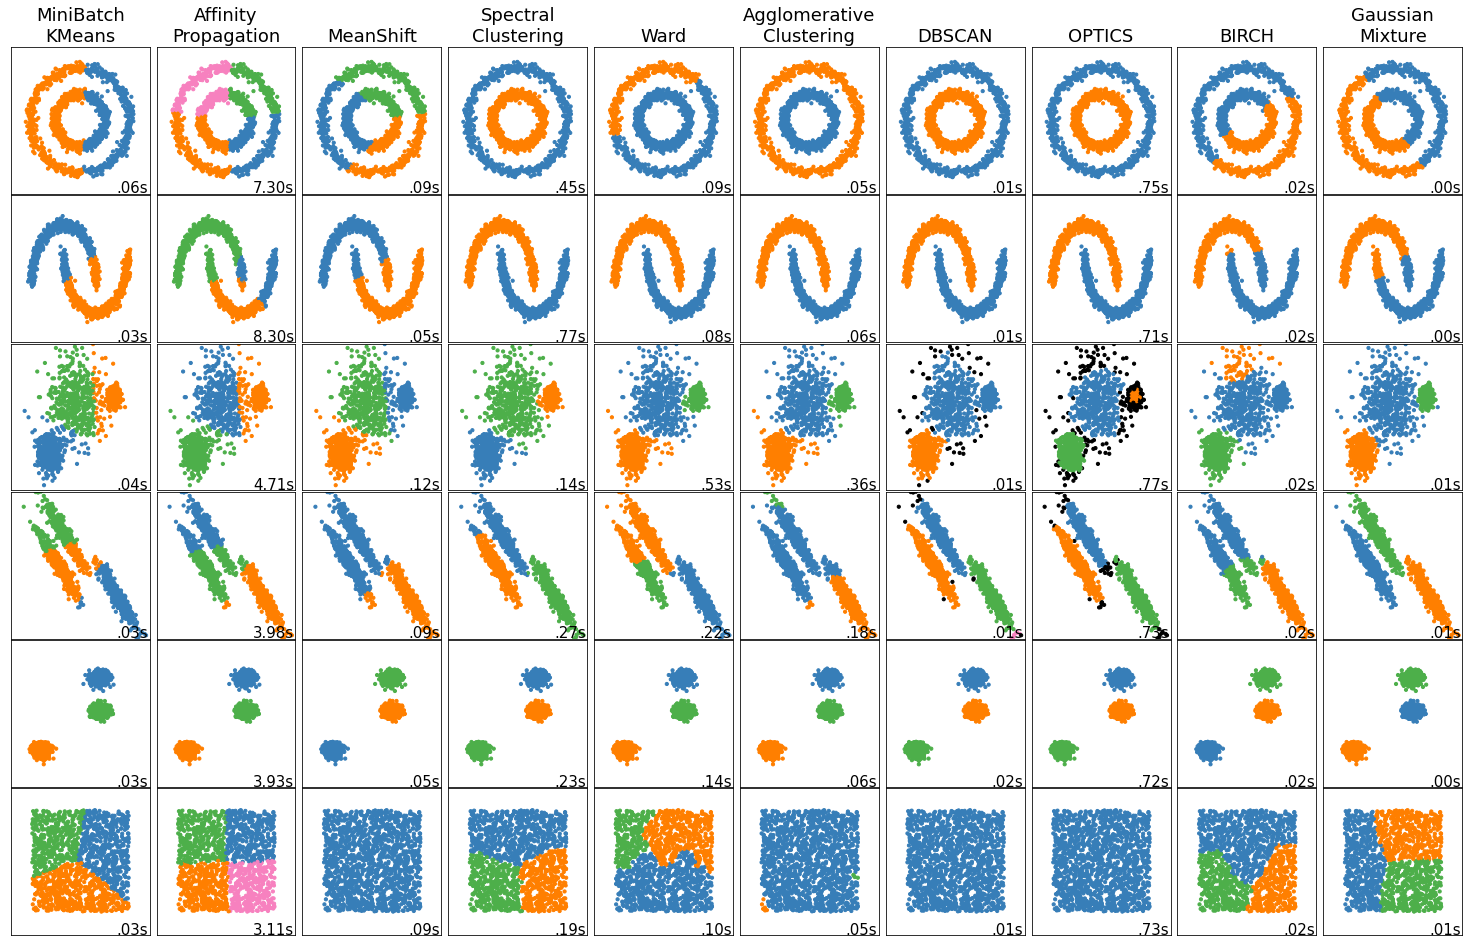

In [12]:
# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.95, wspace=.05,
                    hspace=.01)

plot_num = 1
default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    optics = cluster.OPTICS(min_samples=params['min_samples'],
                            xi=params['xi'],
                            min_cluster_size=params['min_cluster_size'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('MiniBatch\nKMeans', two_means),
        ('Affinity\nPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('Spectral\nClustering', spectral),
        ('Ward', ward),
        ('Agglomerative\nClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('OPTICS', optics),
        ('BIRCH', birch),
        ('Gaussian\nMixture', gmm)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                        "connectivity matrix is [0-9]{1,2}" +
                        " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                        " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()